# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

Team: MammaMia!

Members:
- Lucas Giovanni Uberti-Bona Marín
- Giacomo Anerdi

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [2]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu
0,51624,male,34,White,High School,Married,25000-34999,30000.0,1.36,6.0,...,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0
1,51630,female,49,White,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,...,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0
2,51638,male,9,White,NaN,NaN,75000-99999,87500.0,1.84,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,51646,male,8,White,NaN,NaN,55000-64999,60000.0,2.33,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,51647,female,45,White,College Grad,Married,75000-99999,87500.0,5.00,6.0,...,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0


In [3]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
df_test.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,...,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51625,male,4,Other,NaN,NaN,20000-24999,22500.0,1.07,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51678,male,60,White,High School,Married,15000-19999,17500.0,1.03,5.0,...,NaN,NaN,No,Yes,20.0,1.0,NaN,No,NaN,NaN
2,51694,male,38,White,Some College,Married,20000-24999,22500.0,1.15,6.0,...,No,NaN,No,Yes,23.0,1.0,1.0,No,Heterosexual,NaN
3,51695,male,8,White,NaN,NaN,65000-74999,70000.0,3.55,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51711,female,59,Other,8th Grade,Widowed,20000-24999,22500.0,1.37,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


---
### Data Exploration ###

Initial expection for the data's missing values, quartiles, min/max and standard deviation.

In [5]:
df.describe()

,ID,Age,HHIncomeMid,Poverty,HomeRooms,Weight,Length,HeadCirc,Height,BMI,...,CompHrsDayChild,AlcoholDay,AlcoholYear,SmokeAge,AgeFirstMarij,AgeRegMarij,SexAge,SexNumPartnLife,SexNumPartYear,flu
count,5246.000000,5246.000000,4798.000000,4843.000000,5210.000000,5206.000000,356.000000,61.000000,5014.000000,5010.000000,...,417.000000,2404.000000,2882.000000,1479.000000,1331.000000,629.000000,2673.000000,2773.000000,2405.000000,5246.000000
mean,61707.937286,35.078155,54079.824927,2.614229,6.147025,68.701921,84.363483,41.101639,160.341424,26.371601,...,2.225420,2.959651,72.353921,17.939148,16.983471,17.545310,17.456042,14.617021,1.354678,0.059093
std,5876.826538,23.032443,32956.594998,1.672579,2.223687,29.774856,13.827255,2.381561,21.043275,7.464134,...,2.517635,3.522538,101.779814,5.452497,3.874501,4.478533,3.740811,61.385945,2.503281,0.235820
min,51624.000000,0.000000,2500.000000,0.000000,1.000000,2.800000,47.100000,34.200000,83.600000,12.880000,...,0.000000,1.000000,0.000000,6.000000,1.000000,5.000000,9.000000,0.000000,0.000000,0.000000
25%,56623.250000,15.000000,22500.000000,1.110000,5.000000,53.000000,73.950000,39.600000,155.400000,21.200000,...,0.000000,1.000000,3.000000,15.000000,15.000000,15.000000,15.000000,2.000000,1.000000,0.000000
50%,61669.500000,33.000000,50000.000000,2.320000,6.000000,70.600000,86.150000,41.200000,165.000000,25.700000,...,1.000000,2.000000,24.000000,17.000000,16.000000,17.000000,17.000000,5.000000,1.000000,0.000000
75%,66841.250000,53.000000,87500.000000,4.340000,7.000000,87.300000,95.325000,42.900000,173.600000,30.500000,...,6.000000,3.000000,104.000000,19.000000,18.000000,19.000000,19.000000,12.000000,1.000000,0.000000
max,71915.000000,80.000000,100000.000000,5.000000,13.000000,223.000000,112.200000,45.400000,200.400000,80.600000,...,6.000000,82.000000,364.000000,72.000000,48.000000,52.000000,50.000000,2000.000000,69.000000,1.000000


As it can be seen, many features contain missing values. However, in some of these columns the missing value has meaning. For example a missing value in SmokeAge means that the individual has never smoked.

In [6]:
df.dtypes

ID                    int64
Gender               object
Age                   int64
Race1                object
Education            object
MaritalStatus        object
HHIncome             object
HHIncomeMid         float64
Poverty             float64
HomeRooms           float64
HomeOwn              object
Work                 object
Weight              float64
Length              float64
HeadCirc            float64
Height              float64
BMI                 float64
BMICatUnder20yrs     object
BMI_WHO              object
Pulse               float64
BPSysAve            float64
BPDiaAve            float64
BPSys1              float64
BPDia1              float64
BPSys2              float64
BPDia2              float64
BPSys3              float64
BPDia3              float64
Testosterone        float64
DirectChol          float64
                     ...   
nBabies             float64
Age1stBaby          float64
SleepHrsNight       float64
SleepTrouble         object
PhysActive          

### Analysing different features ###

**Gender**

In [7]:
df['Gender'].isna().sum()

0

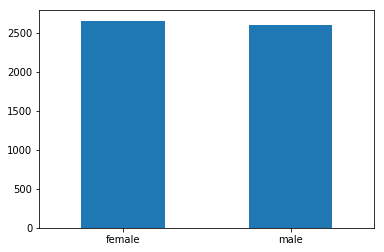

In [8]:
df['Gender'].value_counts().plot.bar(rot=0)
plt.show()

There are no null values in this column. As it can be seen, there the two genders present in the dataset and they are quite balanced.

**Age**

In [9]:
df['Age'].isna().sum()

0

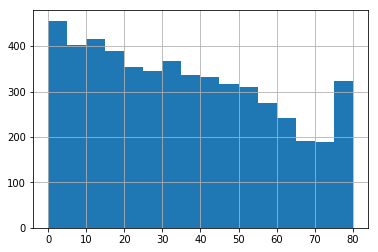

In [10]:
df['Age'].hist(bins=16)
plt.show()

No missing values. It can be observed that the age is not normally distributed in the dataset.

**Race**

In [11]:
df['Race1'].isna().sum()

0

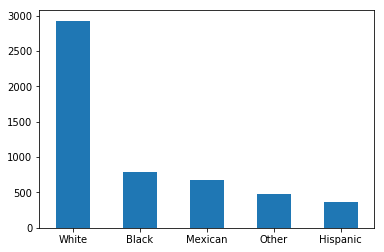

In [12]:
df['Race1'].value_counts().plot.bar(rot=0)
plt.show()

No missing values. As the classes are quite unbalanced where `White` is in the majority of instances it is decided to aggregate the other classes together. This means that the cleaned data just contains whether any given individual is white or not.

**Education**

In [13]:
df['Education'].isna().sum()

1672

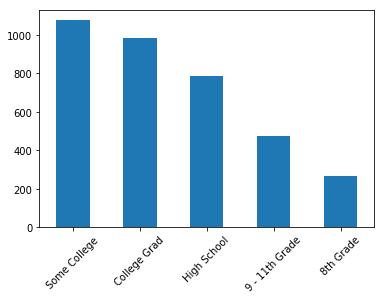

In [14]:
df['Education'].value_counts().plot.bar(rot=45)
plt.show()

In which age groups is the data missing?

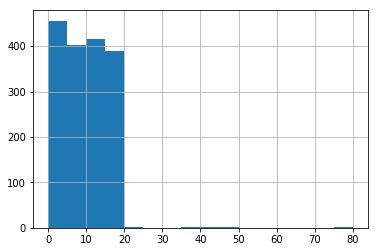

In [15]:
df.loc[df['Education'].isna()]['Age'].hist(bins=16)
plt.show()

In [16]:
dummies = pd.get_dummies(df['Education'])
pd.concat([dummies, df['Age']], axis=1).corr()['Age']

8th Grade         0.188678
9 - 11th Grade    0.172576
College Grad      0.242017
High School       0.226814
Some College      0.222016
Age               1.000000
Name: Age, dtype: float64

1672 instance don't have a value in the 'Education' feature. It looks like this feature tells at what point a given individual has stopped his/her education. This means that the dataset has missing values for young people that are still at school or at university. This is changed into the education level that has been currently achieved by estimating in which education category each individual is using the age.
For the remaining few people with missing values, which are older than 35 years old, it can be assumed that they have finished their education have the values filled in by looking at what is the most prominent category per age group. Depending on different time periods the level of education that people got is different. For example, in the 60s going to university was much less likely than it is today. It can be assumed that the data was collected in the same time period which could be even of a few years. This means that `Age` would be closely related to when any given individual was born.

**Marital Status**

In [17]:
df['MaritalStatus'].isna().sum()

1666

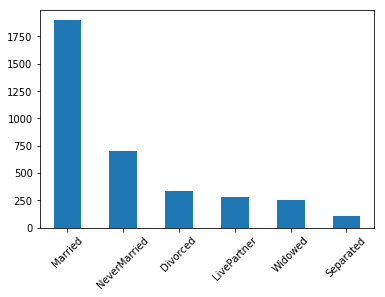

In [18]:
df['MaritalStatus'].value_counts().plot.bar(rot=45)
plt.show()

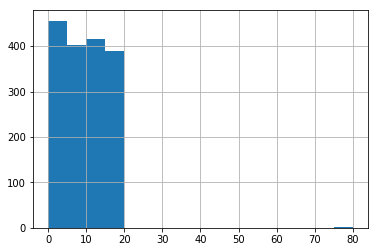

In [19]:
df.loc[df['MaritalStatus'].isna()]['Age'].hist(bins=16)
plt.show()

Similarly to the education example, most missing values arise from young indivuals where it can be assumed that they never married. Instead, for the remaining missing values of the older people, they filled in using the most common label depending on the age group.

**HHIncome**

In [20]:
df['HHIncome'].isna().sum()

448

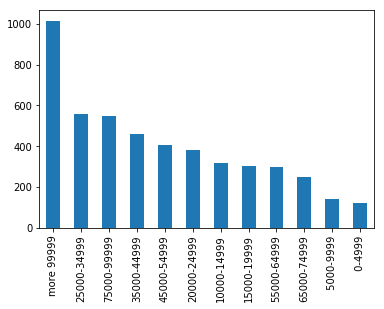

In [21]:
df['HHIncome'].value_counts().plot.bar(rot=90)
plt.show()

This column is not needed as there is already the `HHIncomeMid` column for each category. As a result it is dropped.

**HHIncomeMid**

In [22]:
df['HHIncomeMid'].isna().sum()

448

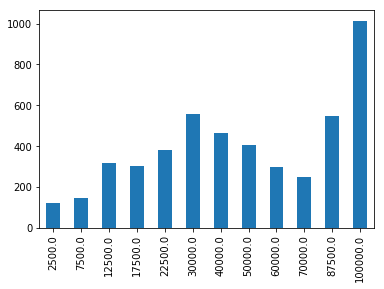

In [23]:
df['HHIncomeMid'].value_counts().sort_index().plot.bar(rot=90)
plt.show()

The missing values are filled in by taking using the median as the data is right skewed.

**Poverty**

In [24]:
df['Poverty'].isna().sum()

403

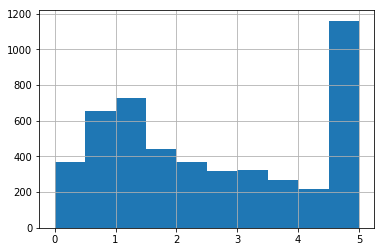

In [25]:
df['Poverty'].hist(bins=10)
plt.show()

A clear distribution cannot be seen. The missing values are filled in by taking the median as the data doesn't follow a clear distribution.

**Home Rooms**

In [26]:
df['HomeRooms'].isna().sum()

36

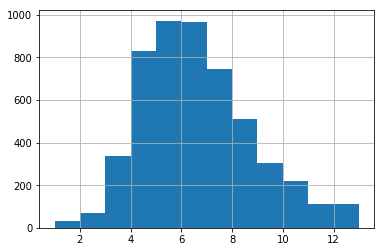

In [27]:
df['HomeRooms'].hist(bins=12)
plt.show()

The data appears to be normally distributed. There are very few data point missing. These are filled in by taking the mean.

**Home Own**

In [28]:
df['HomeOwn'].isna().sum()

33

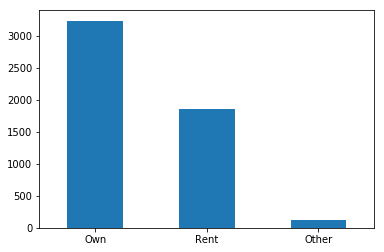

In [29]:
df['HomeOwn'].value_counts().plot.bar(rot=0)
plt.show()

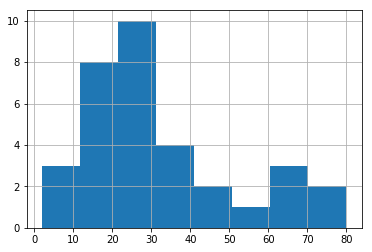

In [30]:
df.loc[df['HomeOwn'].isna()]['Age'].hist(bins=8)
plt.show()

Similarly, there are very few missing values which are filled by using the most common label.

**Work**

In [31]:
df['Work'].isna().sum()

1357

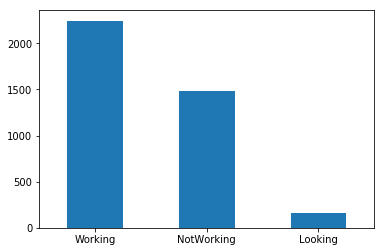

In [32]:
df['Work'].value_counts().plot.bar(rot=0)
plt.show()

In [33]:
len(df[(df['Work'].isna()) & (df['Education'].isna()) & (df['Age']<=20)])

1356

It looks like most of the individuals with missing values in the 'Work' column have not finished their education yet. These are filled with `NotWorking` so that the model can more easily differentiate out of the individuals that are not studying the correlation between `Working` and `Flu`. Remaining are filled by plugging in the most common category.

**Weight**

In [34]:
df['Weight'].isna().sum()

40

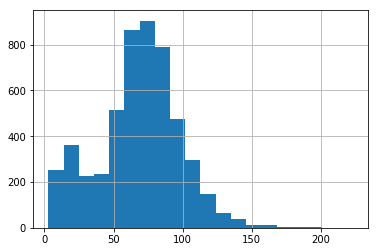

In [35]:
df['Weight'].hist(bins=20)
plt.show()

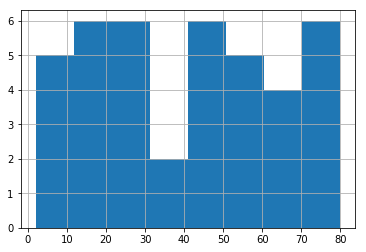

In [36]:
df.loc[df['Weight'].isna()]['Age'].hist(bins=8)
plt.show()

There are few values missing. These are filled in by using the mean of individuals grouped by age.

**Length**

In [37]:
df['Length'].isna().sum()

4890

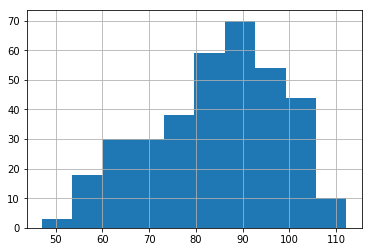

In [38]:
df['Length'].hist()
plt.show()

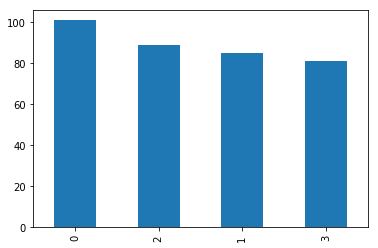

In [39]:
df.loc[df['Length'].notna()]['Age'].value_counts().plot.bar()
plt.show()

This column is only for kids between 0 and 3 years old. This column is merged with the `Height` column as they practically contain the same information.

**Head Circumference**

In [40]:
df['HeadCirc'].notna().sum()

61

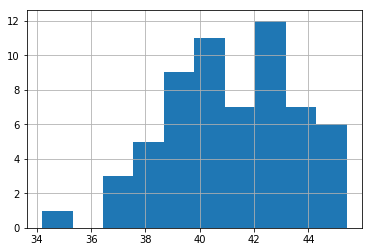

In [41]:
df['HeadCirc'].hist()
plt.show()

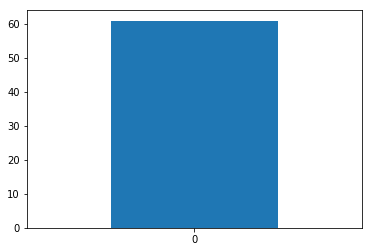

In [42]:
df.loc[df['HeadCirc'].notna()]['Age'].value_counts().plot.bar(rot=0)
plt.show()

In [43]:
len(df.loc[df['Age']==0])

101

Values are present only for babies. However, even many of these instances still have missing values. Therefore, it was decided to drop this feature.

**Height**

In [44]:
df['Height'].isna().sum()

232

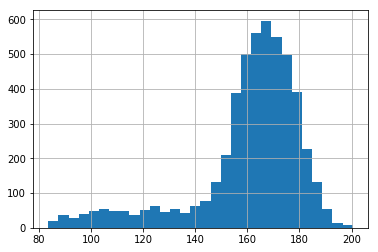

In [45]:
df['Height'].hist(bins=30)
plt.show()

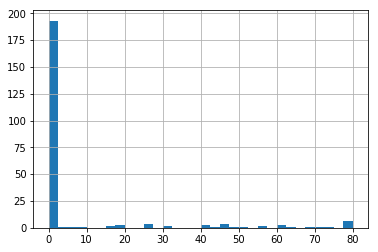

In [46]:
df.loc[df['Height'].isna()]['Age'].hist(bins=32)
plt.show()

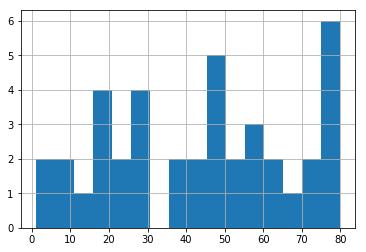

In [47]:
df.loc[(df['Height'].isna()) & (df['Length'].isna())]['Age'].hist(bins=16)
plt.show()

In [48]:
print('Values present in both Height and Length', len(df[(df['Height'].notna()) & (df['Length']).notna()]))
print('Values present in neither Height and Length', len(df[(df['Height'].isna()) & (df['Length']).isna()]))

Values present in both Height and Length 164
Values present in neither Height and Length 40


The data seems to be normally distributed. Most of the missing values are from young children. Where possible the `Length` value is used to fill in the missing values. The remaining missing values are filled in by taking the mean per age group the individual is part of.

**BMI**

In [49]:
df['BMI'].isna().sum()

236

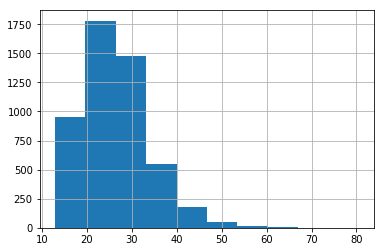

In [50]:
df['BMI'].hist()
plt.show()

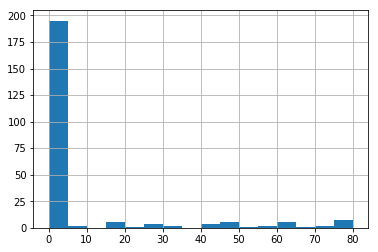

In [51]:
df.loc[df['BMI'].isna()]['Age'].hist(bins=16)
plt.show()

The missing values are calculate using the BMI formula which uses the columns `Height` and `Weight` that have no more missing values.
$$BMI=\frac{\textrm{Weight}}{\textrm{Height}^2}$$

**BMI Category Under 20 years**

In [52]:
df.loc[df['Age'] < 20]['BMICatUnder20yrs'].isna().sum()

941

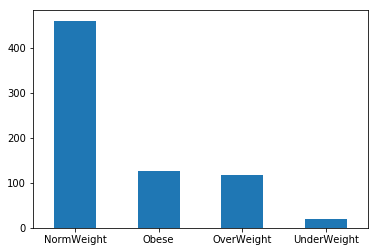

In [53]:
df['BMICatUnder20yrs'].value_counts().plot.bar(rot=0)
plt.show()

Column is dropped as there is a numerical BMI value already which can be seen as being more informative.

**BMI WHO**

In [54]:
df['BMI_WHO'].isna().sum()

256

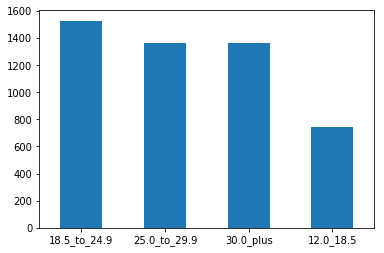

In [55]:
df['BMI_WHO'].value_counts().plot.bar(rot=0)
plt.show()

Column is dropped as there is a numerical BMI value already which can be seen as being more informative.

**Pulse**

In [56]:
df['Pulse'].isna().sum()

870

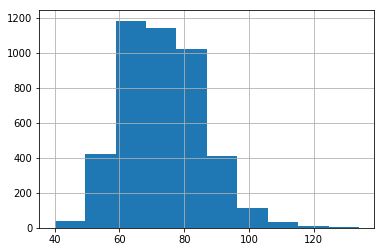

In [57]:
df['Pulse'].hist()
plt.show()

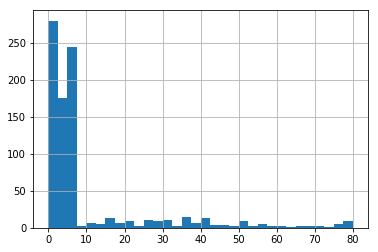

In [58]:
df.loc[df['Pulse'].isna()]['Age'].hist(bins=32)
plt.show()

Most missing values are from kids. 

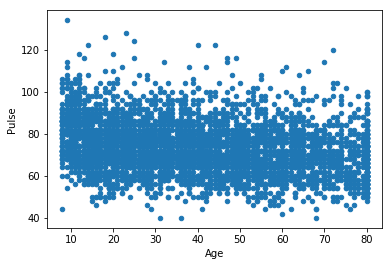

In [59]:
df.plot.scatter('Age', 'Pulse')
plt.show()

Values are filled in with the mean for each age group. A bin size of 10 years is used since as seen from the graph, the values over ages do not drastically change.

**BPSysAve**

In [60]:
df['BPSysAve'].isna().sum()

877

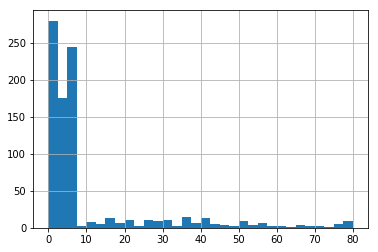

In [61]:
df.loc[df['BPSysAve'].isna()]['Age'].hist(bins=32)
plt.show()

From https://www.stanfordchildrens.org/en/topic/default?id=high-blood-pressure-in-children-and-adolescents-90-P01794 the mean of 105 is manually filled in for kids between 0 and 10 years old as all instances within this age group have `BPSysAve` missing. The remaining missing values for people older than 10 years old is filled in with the mean per age group. Only `BPSysAve` is kept while `BPSys1`, `BPSys2` and `BPSys3` are dropped.

**BPDiaAve**

In [62]:
df['BPDiaAve'].isna().sum()

877

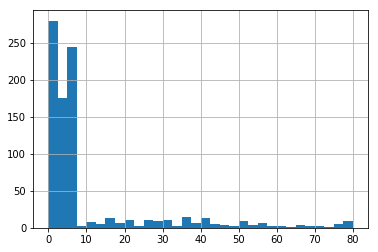

In [63]:
df.loc[df['BPDiaAve'].isna()]['Age'].hist(bins=32)
plt.show()

From https://www.stanfordchildrens.org/en/topic/default?id=high-blood-pressure-in-children-and-adolescents-90-P01794 the mean of 60 is manually filled in for kids between 0 and 10 years old as all instances within this age group have `BPDiaAve` missing. The remaining missing values for people older than 10 years old is filled in with the mean per age group. Only `BPDiaAve` is kept while `BPDia1`, `BPDia2` and `BPDia3` are dropped.

**Testosterone**

In [64]:
df['Testosterone'].isna().sum()

3238

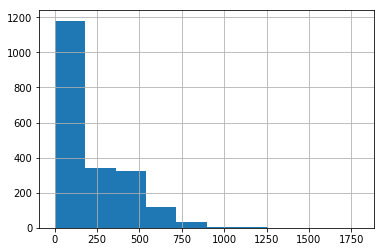

In [65]:
df['Testosterone'].hist()
plt.show()

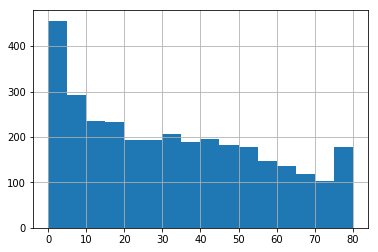

In [66]:
df.loc[df['Testosterone'].isna()]['Age'].hist(bins=16)
plt.show()

There are too many missing values. This column is dropped.

**DirectChol**

In [67]:
df['DirectChol'].isna().sum()

909

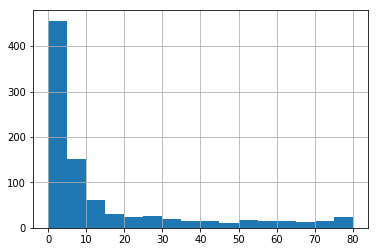

In [68]:
df.loc[df['DirectChol'].isna()]['Age'].hist(bins=16)
plt.show()

In [69]:
df.loc[df['DirectChol'].notna(), 'DirectChol'].head()

0    1.29
1    1.16
2    1.34
3    1.55
4    2.12
Name: DirectChol, dtype: float64

Many unknown values. These are filled using the median as the distribution is skewed to the left.

**TotChol**

In [70]:
df['TotChol'].isna().sum()

909

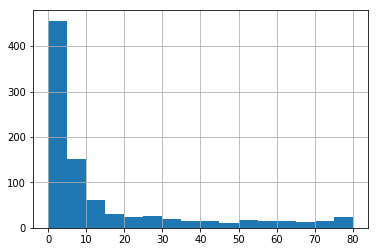

In [71]:
df.loc[df['TotChol'].isna()]['Age'].hist(bins=16)
plt.show()

Many unknown values. These are filled using the median as the distribution is skewed to the left.

**UrineVol1**

In [72]:
df['UrineVol1'].isna().sum()

609

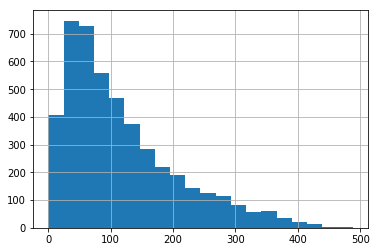

In [73]:
df['UrineVol1'].hist(bins=20)
plt.show()

The missing values are filled in with the median as the distribution is skewed to the left.

**UrineFlow1**

In [74]:
df['UrineFlow1'].isna().sum()

946

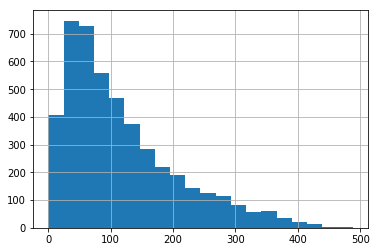

In [75]:
df['UrineVol1'].hist(bins=20)
plt.show()

Likewise, missing values are filled in with the median as the distribution is skewed to the left.

**UrineVol2** and **UrineFlow2**

In [76]:
df['UrineVol2'].isna().sum()

4483

In [77]:
df['UrineFlow2'].isna().sum()

4483

These two columns are dropped as there are too many missing values.

**Diabetes**

In [78]:
df['Diabetes'].isna().sum()

103

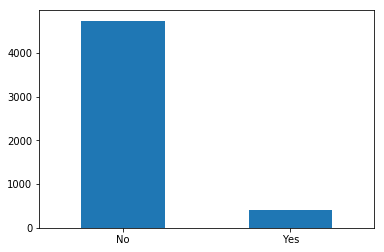

In [79]:
df['Diabetes'].value_counts().plot.bar(rot=0)
plt.show()

In [80]:
df.loc[df['Age'] < 1]['Diabetes'].isna().sum()

101

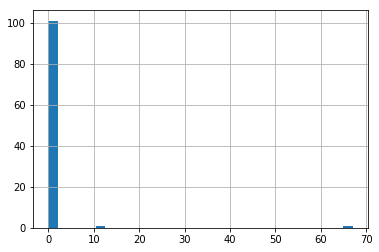

In [81]:
df.loc[df['Diabetes'].isna()]['Age'].hist(bins=32)
plt.show()

Most missing values are from babies where it can be assumed they don't have diabetes. The few remaining ones are also filled with the most common label `No`.

**Diabetes Age**

In [82]:
len(df[(df['DiabetesAge'].isna()) & (df['Diabetes'].isna())])

103

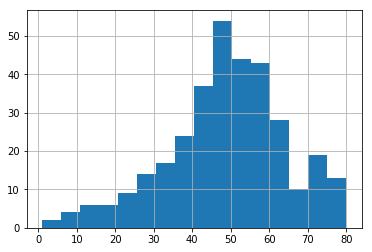

In [83]:
df['DiabetesAge'].hist(bins=16)
plt.show()

Most missing values for this features are because the individuals don't have diabetes. These entries are filled in with a 0. The instances where the data is actually missing is for the same individuals that had a missing value in the `Diabetes` column. Since these missing values were filled with No, the NaN values in the `DiabetesAge` column are also filled with 0. In short, all missing values in this column are filled in with the value 0.

**Health General**

In [84]:
df['HealthGen'].isna().sum()

1463

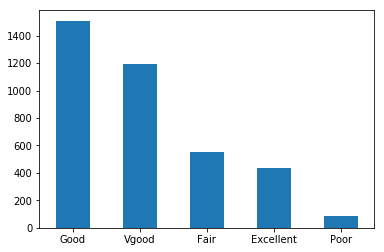

In [85]:
df['HealthGen'].value_counts().plot.bar(rot=0)
plt.show()

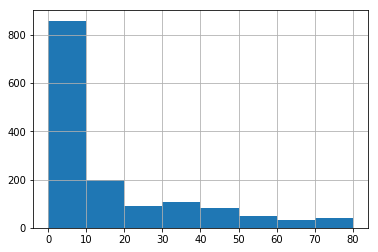

In [86]:
df.loc[df['HealthGen'].isna()]['Age'].hist(bins=8)
plt.show()

In [87]:
df.loc[df['Age'] <= 11]['HealthGen'].notna().sum()

0

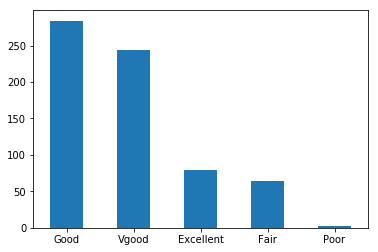

In [88]:
df.loc[df['Age'] <= 20]['HealthGen'].value_counts().plot.bar(rot=0)
plt.show()

Many missing values. Individuals with `Age` $< 12$ are filled in with `Good` as it is the most common label for the entire population. The remaining ones are filled by using the most common label per age group.

**Days Mental Health Bad**

In [89]:
df['DaysMentHlthBad'].isna().sum()

1468

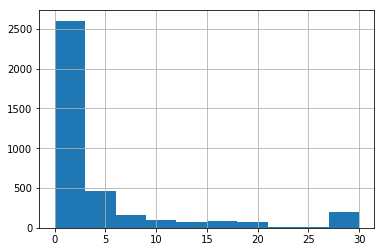

In [90]:
df['DaysMentHlthBad'].hist()
plt.show()

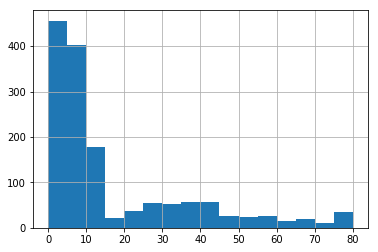

In [91]:
df.loc[df['DaysMentHlthBad'].isna()]['Age'].hist(bins=16)
plt.show()

Most missing values are in younger individuals. For individuals with `Age` $\le 12$ a value of 0 is filled in. The remaining ones are filled in using the mean value per age group.

**Little Interest**

In [92]:
df['LittleInterest'].isna().sum()

1954

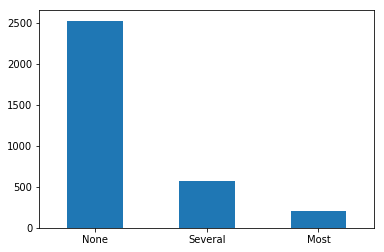

In [93]:
df['LittleInterest'].value_counts().plot.bar(rot=0)
plt.show()

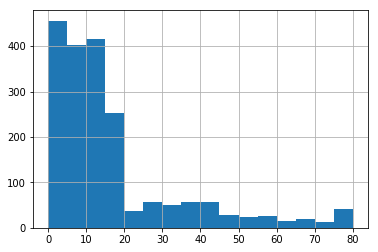

In [94]:
df.loc[df['LittleInterest'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing data but most of it is from the younger individuals. It is assumed that people with `Age` $\le 15$ have a value of `None` and the rest are filled in by taking the most common label per age group. 

**Depressed**

In [95]:
df['Depressed'].isna().sum()

1951

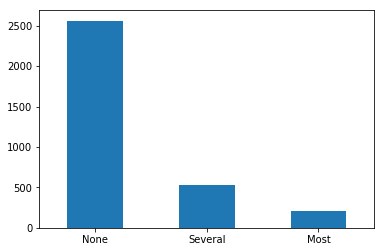

In [96]:
df['Depressed'].value_counts().plot.bar(rot=0)
plt.show()

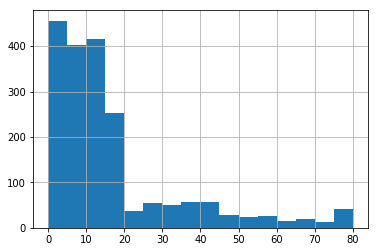

In [97]:
df.loc[df['Depressed'].isna()]['Age'].hist(bins=16)
plt.show()

Similarly to the `LittleInterest` feature, a large amount of the missing data is from the younger individuals. It is assumed that people less than with `Age` $\le 15$ have a value of 0 and the rest are filled in by taking the mean per age group. 

**Number Pregnancies**

In [98]:
len(df[(df['nPregnancies'].isna()) & (df['Gender']=='female')])

1370

In [99]:
len(df[df['nPregnancies']==0])

0

In [100]:
len(df[(df['nPregnancies'].isna()) & (df['nBabies']>0)])

0

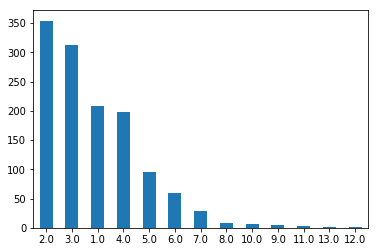

In [101]:
df['nPregnancies'].value_counts().plot.bar(rot=0)
plt.show()

In [102]:
len(df[(df['nPregnancies'].notna()) & (df['Gender']=='male')])

0

It looks like there is never the value 0. It is then assumed that a null value means that the individual has had 0 pregnancies. As a sanity check, there are no males that have had a pregnancy.

**Number Babies**

In [103]:
len(df[(df['nPregnancies'].notna()) & (df['nBabies']).isna()])

101

In [104]:
len(df[df['nBabies']==0])

4

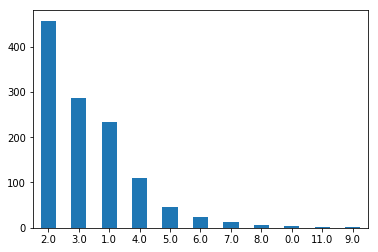

In [105]:
df['nBabies'].value_counts().plot.bar(rot=0)
plt.show()

How many instances have the amount of pregnancies different from the amount of babies?

In [106]:
len(df[(df['nPregnancies'] != df['nBabies']) & (df['nBabies'].notna())])

455

Are there instances where the amount of pregnancies is less than the amount of babies?

In [107]:
len(df[(df['nPregnancies'] < df['nBabies']) & (df['nBabies'].notna())])

0

In [108]:
len(df[(df['nPregnancies'].notna()) & (df['nBabies'].isna())])

101

Similarly to `nPregnancies`, all missing values are filled instances with missing `nBabies` and 0 `nPregnancies` are filled in with 0.

**Age 1st Baby**

In [109]:
len(df[(df['nBabies']!=0) & (df['Age1stBaby']).isna()])

4301

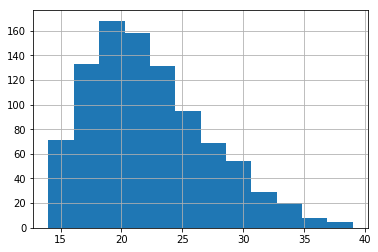

In [110]:
df['Age1stBaby'].hist(bins=12)
plt.show()

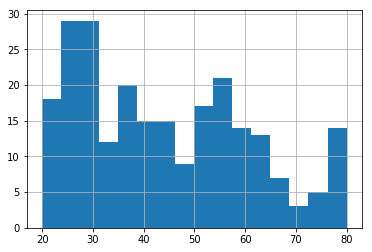

In [111]:
df.loc[(df['nBabies'].notna()) & (df['Age1stBaby'].isna())]['Age'].hist(bins=16)
plt.show()

The data appears to be normally distributed. Missing values where `nBabies` is 0 are filled in with 0. 

**Sleep Hours Night**

In [112]:
df['SleepHrsNight'].isna().sum()

1367

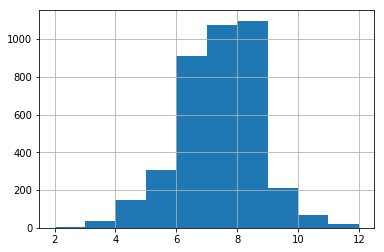

In [113]:
df['SleepHrsNight'].hist()
plt.show()

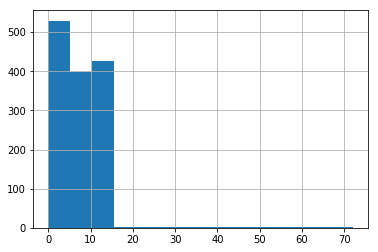

In [114]:
df.loc[df['SleepHrsNight'].isna()]['Age'].hist(bins=14)
plt.show()

In [115]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['SleepHrsNight'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 83), (17, 81), (18, 67), (19, 78), (20, 76), (21, 74), (22, 71), (23, 65), (24, 66), (25, 69), (26, 64), (27, 58), (28, 85), (29, 68), (30, 81), (31, 84), (32, 71), (33, 70), (34, 60), (35, 50), (36, 68), (37, 63), (38, 69), (39, 86), (40, 74), (41, 65), (42, 54), (43, 73), (44, 66), (45, 60), (46, 59), (47, 65), (48, 68), (49, 65), (50, 69), (51, 59), (52, 52), (53, 55), (54, 73), (55, 53), (56, 77), (57, 46), (58, 44), (59, 53), (60, 57), (61, 36), (62, 40), (63, 57), (64, 51), (65, 59), (66, 31), (67, 34), (68, 40), (69, 27), (70, 53), (71, 34), (72, 33), (73, 27), (74, 40), (75, 28), (76, 30), (77, 27), (78, 25), (79, 24)]


All individuals with `Age` $\le 15$ have missing values. For these instances the values are manually inputted by using the average sleep time got from https://www.sleepfoundation.org/press-release/national-sleep-foundation-recommends-new-sleep-times. For the remaining people, the sleep hours per night is found by taking the mean of the age group each particular person is part of.

**Sleep Trouble**

In [116]:
df['SleepTrouble'].isna().sum()

1356

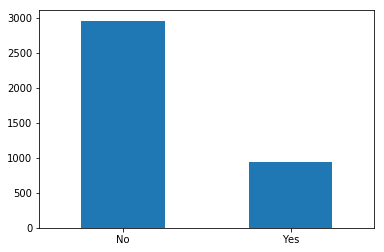

In [117]:
df['SleepTrouble'].value_counts().plot.bar(rot=0)
plt.show()

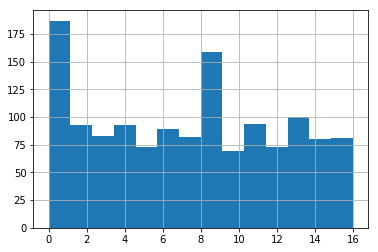

In [118]:
df.loc[df['SleepTrouble'].isna()]['Age'].hist(bins=14)
plt.show()

All missing values come from individuals with an age smaller or equal to 16. All these values are assumed to be `No` as younger people are less likely to have sleep trouble.

**Physically Active**

In [119]:
df['PhysActive'].isna().sum()

1042

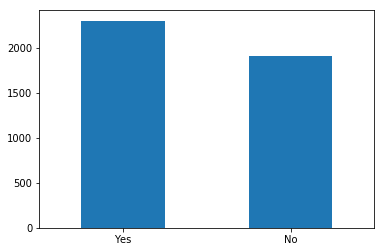

In [120]:
df['PhysActive'].value_counts().plot.bar(rot=0)
plt.show()

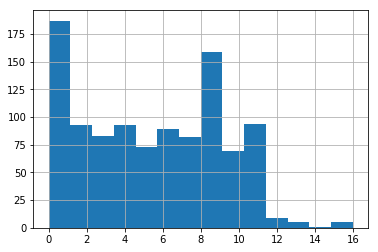

In [121]:
df.loc[df['PhysActive'].isna()]['Age'].hist(bins=14)
plt.show()

In [122]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['PhysActive'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 64), (13, 95), (14, 79), (15, 76), (16, 83), (17, 81), (18, 67), (19, 78), (20, 76), (21, 74), (22, 71), (23, 65), (24, 67), (25, 69), (26, 65), (27, 58), (28, 85), (29, 68), (30, 81), (31, 84), (32, 71), (33, 70), (34, 61), (35, 50), (36, 68), (37, 63), (38, 70), (39, 86), (40, 74), (41, 65), (42, 55), (43, 73), (44, 66), (45, 60), (46, 59), (47, 65), (48, 68), (49, 65), (50, 69), (51, 60), (52, 52), (53, 55), (54, 74), (55, 53), (56, 77), (57, 46), (58, 44), (59, 54), (60, 58), (61, 36), (62, 40), (63, 57), (64, 51), (65, 60), (66, 31), (67, 34), (68, 40), (69, 27), (70, 53), (71, 34), (72, 34), (73, 27), (74, 40), (75, 28), (76, 30), (77, 27), (78, 25), (79, 24)]


For kids with `Age` $\le 4$ years old, `No` is inserted. All the individuals where $5 \ge$`Age` $15 \le$ are assumed to have physical activity. The remaining missing values for the population older than $15$ years old the most common value per age group is inserted.

**Physically Active Days**

In [123]:
df['PhysActiveDays'].isna().sum()

2872

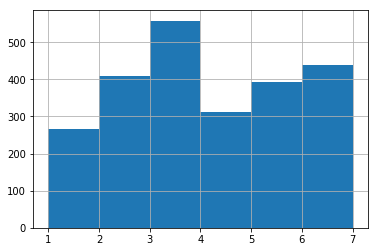

In [124]:
df['PhysActiveDays'].hist(bins=6)
plt.show()

There are too many missing values and as a result this column is dropped.

**TV Hours per Day**

In [125]:
df['TVHrsDay'].isna().sum()

2829

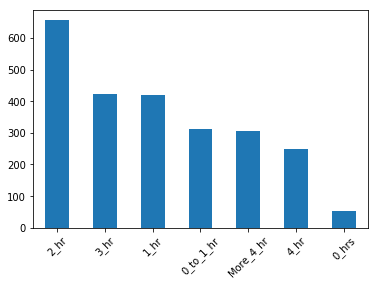

In [126]:
df['TVHrsDay'].value_counts().plot.bar(rot=45)
plt.show()

There are too many missing values and as a result this column is dropped.

**Computer Hours per Day**

In [127]:
df['CompHrsDay'].isna().sum()

2827

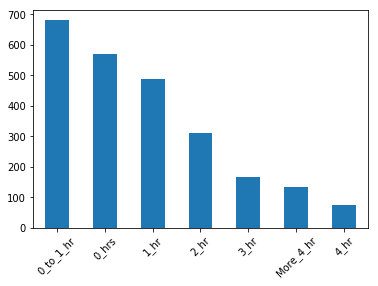

In [128]:
df['CompHrsDay'].value_counts().plot.bar(rot=45)
plt.show()

There are too many missing values and as a result this column is dropped.

**TV Hours per Day Child**

In [129]:
df['TVHrsDayChild'].isna().sum()

4829

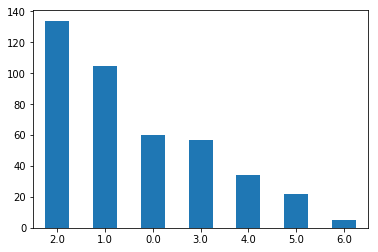

In [130]:
df['TVHrsDayChild'].value_counts().plot.bar(rot=0)
plt.show()

There are too many missing values and as a result this column is dropped.

**Computer Hours per Day Child**

In [131]:
df['TVHrsDayChild'].isna().sum()

4829

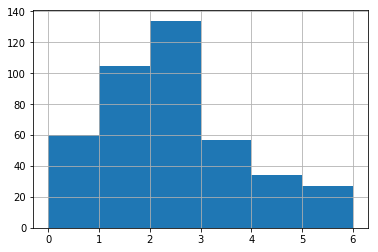

In [132]:
df['TVHrsDayChild'].hist(bins=6)
plt.show()

There are too many missing values and as a result this column is dropped.

**Alcohol 12+ Years**

In [133]:
df['Alcohol12PlusYr'].isna().sum()

2014

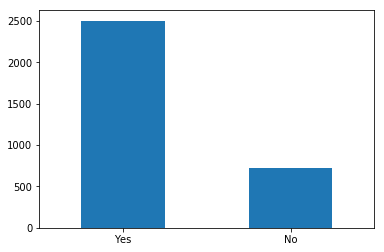

In [134]:
df['Alcohol12PlusYr'].value_counts().plot.bar(rot=0)
plt.show()

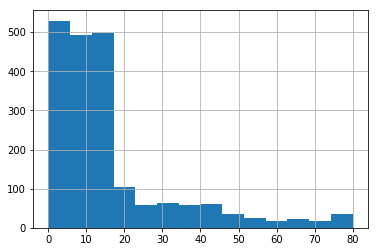

In [135]:
df.loc[df['Alcohol12PlusYr'].isna()]['Age'].hist(bins=14)
plt.show()

In [136]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['Alcohol12PlusYr'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 30), (19, 35), (20, 68), (21, 69), (22, 61), (23, 60), (24, 58), (25, 53), (26, 59), (27, 50), (28, 72), (29, 56), (30, 71), (31, 73), (32, 62), (33, 61), (34, 49), (35, 41), (36, 56), (37, 56), (38, 56), (39, 71), (40, 64), (41, 53), (42, 40), (43, 61), (44, 59), (45, 55), (46, 52), (47, 63), (48, 61), (49, 59), (50, 67), (51, 48), (52, 50), (53, 52), (54, 70), (55, 50), (56, 66), (57, 45), (58, 39), (59, 49), (60, 53), (61, 34), (62, 39), (63, 53), (64, 49), (65, 54), (66, 28), (67, 31), (68, 36), (69, 23), (70, 49), (71, 31), (72, 32), (73, 25), (74, 38), (75, 22), (76, 25), (77, 23), (78, 22), (79, 21)]


All values are missing for people younger than 18 years old. These are filled with a `No`. the remaining ones are filled by taking the most common value per age group each given individual is part of.

**Alcohol Day**

In [137]:
df['AlcoholDay'].isna().sum()

2842

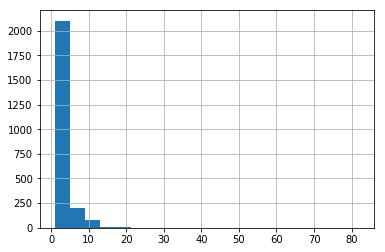

In [138]:
df['AlcoholDay'].hist(bins=20)
plt.show()

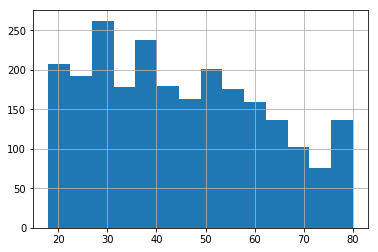

In [139]:
df.loc[df['AlcoholDay'].notna()]['Age'].hist(bins=14)
plt.show()

Again, people younger than 18 years old have all the values missing which are then filled with a 0. The remaining ones are filled by taking the most common value per age group each given individual is part of.

**Alcohol Year**

In [140]:
df['AlcoholYear'].isna().sum()

2364

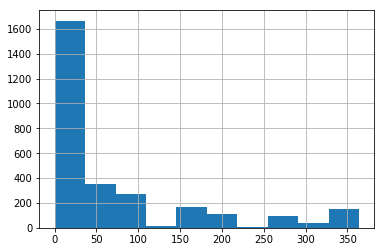

In [141]:
df['AlcoholYear'].hist()
plt.show()

Same as the `AlcoholDay` column, people younger than 18 years old have all the values missing which are then filled with a 0. The remaining ones are filled by taking the most common value per age group each given individual is part of.

**Smoke Now**

In [142]:
df['SmokeNow'].isna().sum()

3707

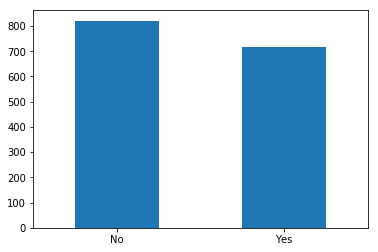

In [143]:
df['SmokeNow'].value_counts().plot.bar(rot=0)
plt.show()

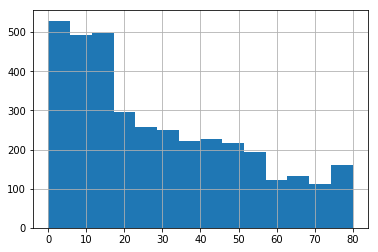

In [144]:
df.loc[df['SmokeNow'].isna()]['Age'].hist(bins=14)
plt.show()

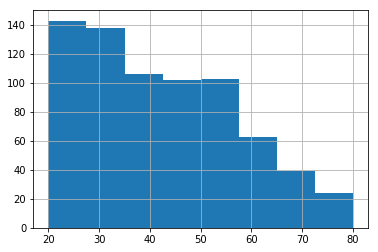

In [145]:
df.loc[df['SmokeNow']=='Yes']['Age'].hist(bins=8)
plt.show()

All people of 20 years old or younger have missing values. These are filled with `No`. The remaining missing values for the older people, are filled in using the most common label depending on the age group they are part of.

**Smoke Past 100 Months**

In [146]:
df['Smoke100'].isna().sum()

1665

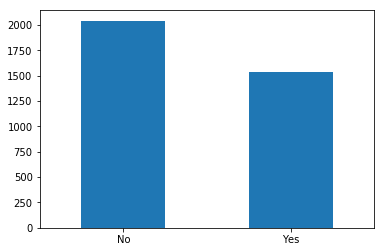

In [147]:
df['Smoke100'].value_counts().plot.bar(rot=0)
plt.show()

In [148]:
len(df.loc[(df['Smoke100'].isna()) & (df['Age']>=20)])

0

All missing values are from individuals younger than 20 years old. As these people are assumed to not smoke, it follows that they should not identify as smokers. This means that all the missing values are filled in with `No`.

**Smoker Identify**

In [149]:
df['Smoke100n'].isna().sum()

1665

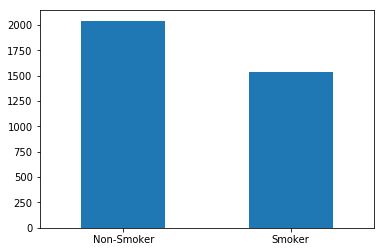

In [150]:
df['Smoke100n'].value_counts().plot.bar(rot=0)
plt.show()

Just like the `Smoke100` feature, all missing values are from individuals younger than 20 years old. Therefore, all these people it assumed that they do not smoke.

**Smoke Age**

In [151]:
df['SmokeAge'].isna().sum()

3767

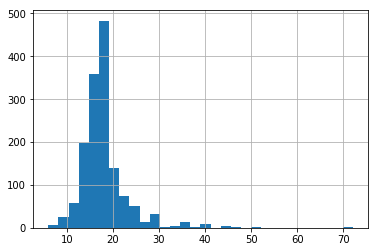

In [152]:
df['SmokeAge'].hist(bins=30)
plt.show()

In [153]:
len(df.loc[(df['SmokeNow']=='Yes') & (df['SmokeAge'].isna())])

15

Tha data appears to be normally distributed. The individuals which have the value `No` in the `SmokeNow` column have their entry filled with a 0. The few entries of `SmokeAge` of people that smoke but have a missing value are filled in by taking the mean of the age group a given individual is part of.

**Marijuana**

In [154]:
df['Marijuana'].isna().sum()

2835

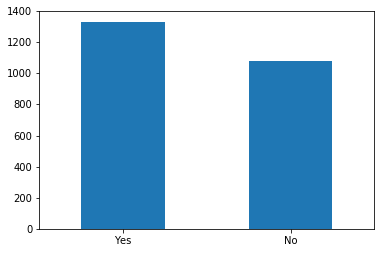

In [155]:
df['Marijuana'].value_counts().plot.bar(rot=0)
plt.show()

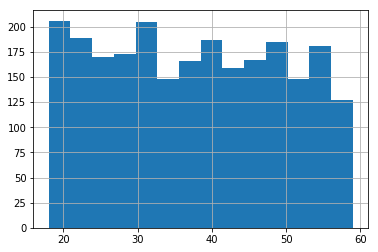

In [156]:
df.loc[df['Marijuana'].notna()]['Age'].hist(bins=14)
plt.show()

In [157]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['Marijuana'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 59), (24, 58), (25, 53), (26, 59), (27, 49), (28, 70), (29, 54), (30, 71), (31, 72), (32, 62), (33, 60), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 52), (42, 40), (43, 61), (44, 58), (45, 53), (46, 52), (47, 62), (48, 61), (49, 58), (50, 66), (51, 47), (52, 49), (53, 52), (54, 70), (55, 48), (56, 63), (57, 41), (58, 39), (59, 47), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


In [158]:
len(df.loc[(df['Marijuana'].isna()) & (df['SmokeNow']=='Yes')])

178

The individuals which have the value `No` in the `SmokeNow` column have their entry filled with a `No` in the `Marijuana` column as well.  

**Age First Marijuana**

In [159]:
df['AgeFirstMarij'].isna().sum()

3915

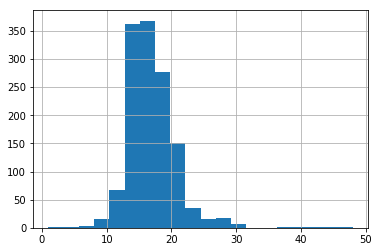

In [160]:
df['AgeFirstMarij'].hist(bins=20)
plt.show()

In [161]:
len(df.loc[(df['Marijuana']=='Yes') & (df['AgeFirstMarij'].isna())])

1

Most missing values are from people that do not smoke marijuana. The entries for these instance are therefore filled with a 0. The remaining missing values are filled with the mean of the age group the given individual is part of.

**Regular Marijuana**

In [162]:
df['RegularMarij'].isna().sum()

2835

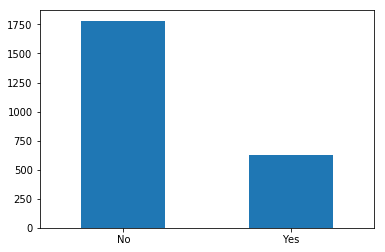

In [163]:
df['RegularMarij'].value_counts().plot.bar(rot=0)
plt.show()

In [164]:
len(df.loc[(df_test['Marijuana']=='Yes') & (df['RegularMarij'].isna())])

213

Instances that have `No` in the `Marijuana` feature have their missing value in `RegularMarij` set to `No` as well. The remaining missing values, if any, are filled in by using the most common value of the age group the given individual is part of.

**Age Regular Marijuana**

In [165]:
df['AgeRegMarij'].isna().sum()

4617

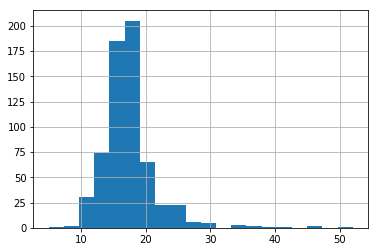

In [166]:
df['AgeRegMarij'].hist(bins=20)
plt.show()

In [167]:
len(df[(df['AgeRegMarij'].isna()) & (df['Marijuana'] == 'Yes')])

703

Similarly, instances that have `No` in the `Marijuana` feature have their missing value in `AgeRegMarij` set to 0. The remaining missing values, are filled in by using the mean value of the age group the given individual is part of.

**Hard Drugs**

In [168]:
df['HardDrugs'].isna().sum()

2448

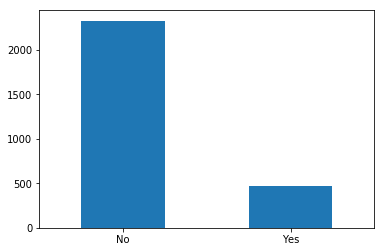

In [169]:
df['HardDrugs'].value_counts().plot.bar(rot=0)
plt.show()

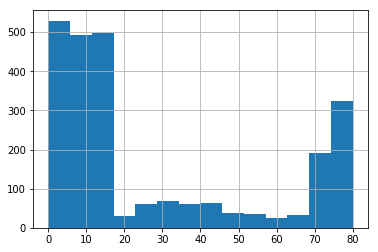

In [170]:
df.loc[df['HardDrugs'].isna()]['Age'].hist(bins=14)
plt.show()

In [171]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['HardDrugs'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 59), (24, 58), (25, 53), (26, 59), (27, 49), (28, 70), (29, 54), (30, 71), (31, 72), (32, 62), (33, 60), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 52), (42, 40), (43, 61), (44, 58), (45, 54), (46, 52), (47, 63), (48, 61), (49, 58), (50, 67), (51, 47), (52, 49), (53, 52), (54, 70), (55, 47), (56, 63), (57, 42), (58, 39), (59, 47), (60, 49), (61, 33), (62, 38), (63, 51), (64, 47), (65, 53), (66, 26), (67, 30), (68, 34), (69, 23), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


Instances where the value is missing and `Age` $\le 18$ have the `HardDrugs` attribute set to `No`. The remaining missing values, are filled in by using the most common value of the age group the given individual is part of.

**Sex Ever**

In [172]:
df['SexEver'].isna().sum()

2450

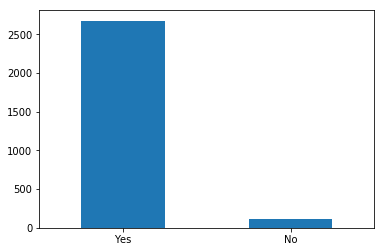

In [173]:
df['SexEver'].value_counts().plot.bar(rot=0)
plt.show()

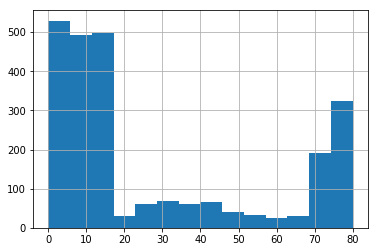

In [174]:
df.loc[df['SexEver'].isna()]['Age'].hist(bins=14)
plt.show()

The missing values are filled in the following way. If the individual's age is less than the mode of `SexAge`, then the entry is filled with `No`. Otherwise, it is filled with `Yes`. 

**Sex Age**

In [175]:
df['SexAge'].isna().sum()

2573

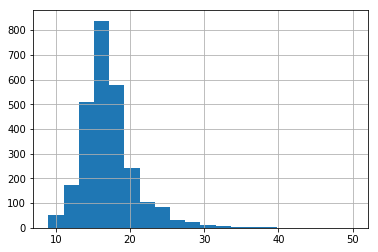

In [176]:
df['SexAge'].hist(bins=20)
plt.show()

In [177]:
len(df.loc[(df['SexAge'].isna()) & (df['SexEver'].notna())])

123

This feature appears to be normally distributed. Instances where there is a missing value and `SexEver` is `No` are filled with 0. The remaining missing values are filled in with `Yes`.

**Sex Number of Partners Life**

In [178]:
df['SexNumPartnLife'].isna().sum()

2473

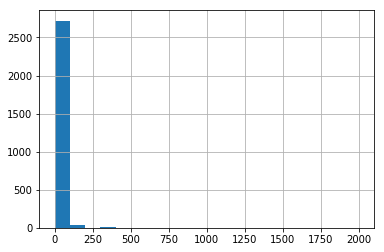

In [179]:
df['SexNumPartnLife'].hist(bins=20)
plt.show()

In [180]:
len(df[(df['SexNumPartnLife'].isna()) & (df['SexEver'] == 'Yes')])

23

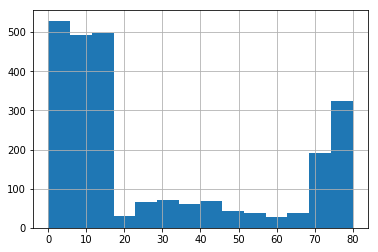

In [181]:
df.loc[df['SexNumPartnLife'].isna()]['Age'].hist(bins=14)
plt.show()

In [182]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['SexNumPartnLife'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 58), (24, 58), (25, 52), (26, 58), (27, 48), (28, 70), (29, 54), (30, 70), (31, 72), (32, 61), (33, 59), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 51), (42, 40), (43, 59), (44, 58), (45, 53), (46, 51), (47, 61), (48, 61), (49, 58), (50, 66), (51, 47), (52, 49), (53, 52), (54, 66), (55, 48), (56, 64), (57, 41), (58, 38), (59, 47), (60, 49), (61, 33), (62, 37), (63, 51), (64, 46), (65, 53), (66, 27), (67, 27), (68, 32), (69, 23), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


Missing values for people that have the `SexEver` attribute to `No` are filled in with 0. The remaining missing values are filled in by using the mean of the age group that the given individual is part of. However the dataset doesn't contain any value for people of 70 years or older. These values are filled in by using the mean of the instances with $60 \ge$ `SexNumPartnLife` $< 70$ as it is presumed that this value does not greatly change between the two age groups.

**Sex Number of Parners Year**

In [183]:
df['SexNumPartYear'].isna().sum()

2841

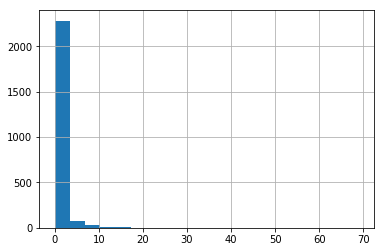

In [184]:
df['SexNumPartYear'].hist(bins=20)
plt.show()

In [185]:
len(df[(df['SexNumPartYear'].isna()) & (df['SexEver'] == 'Yes')])

382

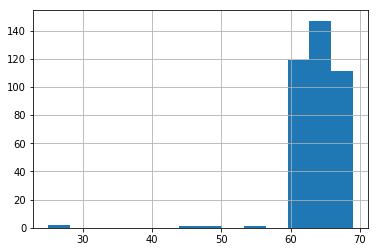

In [186]:
df.loc[(df['SexNumPartYear'].isna()) & (df['SexEver'] == 'Yes')]['Age'].hist(bins=14)
plt.show()

Similartly to `SexNumPartnLife`, missing values for people that have the `SexEver` attribute to `No` are filled in with 0. The remaining missing values are filled in by using the mean of the age group that the given individual is part of. However the dataset doesn't contain any value for people of 70 years or older. These values are filled in by using the mean of the instances with $60 \ge$ `SexNumPartnYear` $< 70$ as it is presumed that this value does not greatly change between the two age groups.

**Same Sex**

In [187]:
df['SameSex'].isna().sum()

2448

In [188]:
len(df.loc[(df['SameSex'].isna()) & (df['SexEver']=='Yes')])

2

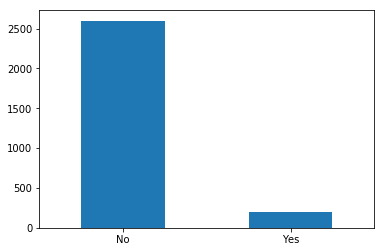

In [189]:
df['SameSex'].value_counts().plot.bar(rot=0)
plt.show()

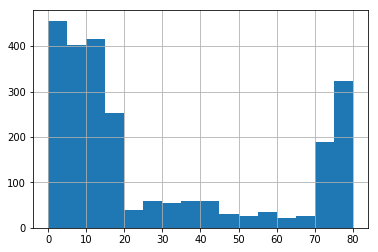

In [190]:
df.loc[df['SameSex'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing values. Mostly for the younger and older age groups. As such this column is removed.

**Sex Orientation**

In [191]:
len(df.loc[(df['SexOrientation'].isna()) & (df['Age'] >= 14)])

1694

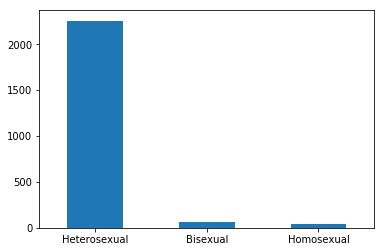

In [192]:
df['SexOrientation'].value_counts().plot.bar(rot=0)
plt.show()

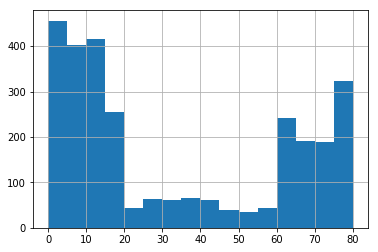

In [193]:
df.loc[df['SexOrientation'].isna()]['Age'].hist(bins=16)
plt.show()

This column is dropped as there are too many missing values.

**Pregnant Now**

In [194]:
len(df.loc[(df['PregnantNow'].isna()) & (df['Gender'] == 'female')])

1770

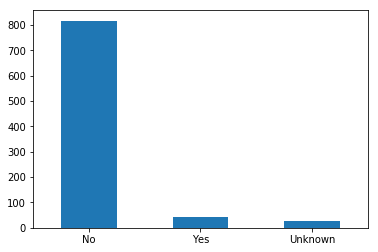

In [195]:
df['PregnantNow'].value_counts().plot.bar(rot=0)
plt.show()

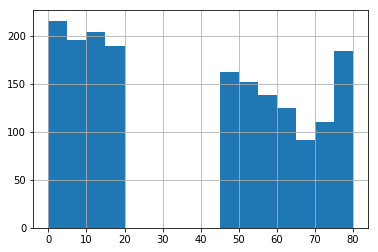

In [196]:
df.loc[(df['PregnantNow'].isna()) & (df['Gender'] == 'female')]['Age'].hist(bins=16)
plt.show()

All missing values are either from males or people that are less than 20 years old or more than 45 years old. As such it can be assumed that all individual with missing values are not pregnant.

**Flu**

In [197]:
df['flu'].isna().sum()

0

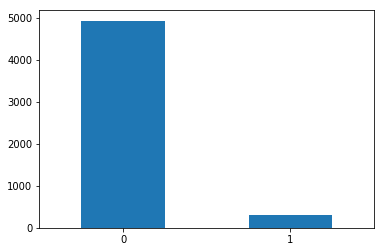

In [198]:
df['flu'].value_counts().plot.bar(rot=0)
plt.show()

There are no rows with flu value missing that would need to be dropped.

## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

# Cleaning, normalization and data splits

In [199]:
def fill_bin_num(dataframe, feature, bin_feature, bin_size, stat_measure, min_bin=None, max_bin=None, default_val='No'):
    if min_bin is None:
        min_bin = dataframe[bin_feature].min()
    if max_bin is None:
        max_bin = dataframe[bin_feature].max()
    new_dataframe = dataframe.copy()
    df_meancat = pd.DataFrame(columns=['interval', 'stat_measure'])
    for num_bin, subset in dataframe.groupby(pd.cut(dataframe[bin_feature], np.arange(min_bin, max_bin+bin_size, bin_size), include_lowest=True)):
        if stat_measure is 'mean':
            row = [num_bin, subset[feature].mean()]
        elif stat_measure is 'mode': 
            mode_ar = subset[feature].mode().values
            if len(mode_ar) > 0:
                row = [num_bin, mode_ar[0]]
            else:
                row = [num_bin, default_val]
        else:
            raise Exception('Unknown statistical measure: ' + stat_measure)
        df_meancat.loc[len(df_meancat)] = row
    for index, row_df in dataframe[dataframe[feature].isna()].iterrows():
        for _, row_meancat in df_meancat.iterrows():
            if row_df[bin_feature] in row_meancat['interval']:
                new_dataframe.at[index, feature] = row_meancat['stat_measure']
    return new_dataframe


def make_dummy_cols(dataframe, column, prefix, drop_dummy):
    dummy = pd.get_dummies(dataframe[column], prefix=prefix)
    dummy = dummy.drop(columns=prefix+'_'+drop_dummy)
    dataframe = pd.concat([dataframe, dummy], axis=1)
    dataframe = dataframe.drop(columns=column)
    return dataframe


def cleaning(dataframe_raw):
    dataframe = dataframe_raw.copy()

    dataframe = dataframe.set_index('ID')

    dataframe.loc[(dataframe['Age']<=13) & (dataframe['Education'].isna()), 'Education'] = 'Lower School/Kindergarten'
    dataframe.loc[(dataframe['Age']==14) & (dataframe['Education'].isna()), 'Education'] = '8th Grade'
    dataframe.loc[(dataframe['Age']<=17) & (dataframe['Education'].isna()), 'Education'] = '9 - 11th Grade'
    dataframe.loc[(dataframe['Age']<=21) & (dataframe['Education'].isna()), 'Education'] = 'High School'
    dataframe['Education'] = dataframe['Education'].fillna('Some College')

    dataframe.loc[(dataframe['Age']<=20) & (dataframe['MaritalStatus'].isna()), 'MaritalStatus'] = 'NeverMarried'
    dataframe.at[dataframe['MaritalStatus'].isna(), 'MaritalStatus'] = fill_bin_num(dataframe, 'MaritalStatus', 'Age', 5, 'mode',20)

    dataframe = dataframe.drop(columns=['HHIncome'])

    dataframe.loc[dataframe['HHIncomeMid'].isna(), 'HHIncomeMid'] = dataframe['HHIncomeMid'].median()

    dataframe.loc[dataframe['Poverty'].isna(), 'Poverty'] = dataframe['Poverty'].median()

    dataframe.loc[dataframe['HomeRooms'].isna(), 'HomeRooms'] = dataframe['HomeRooms'].mean()

    dataframe.loc[dataframe['HomeOwn'].isna(), 'HomeOwn'] = dataframe['HomeOwn'].mode().values[0]

    dataframe.loc[(dataframe['Work'].isna()) & (dataframe['Education'].isna()) & (dataframe['Age']<=20), 'Work'] = 'NotWorking'

    dataframe.loc[dataframe['Work'].isna(), 'Work'] = dataframe['Work'].mode().values[0]

    dataframe = fill_bin_num(dataframe, 'Weight', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['HeadCirc'])

    for index, row in dataframe.iterrows():
        if np.isnan(row['Height']) and not np.isnan(row['Length']):
            dataframe.at[index, 'Height'] = row['Length']
    dataframe = fill_bin_num(dataframe, 'Height', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['Length'])

    for index, row in dataframe[dataframe['BMI'].isna()].iterrows():
        dataframe.at[index, 'BMI'] = row['Weight'] / ((row['Height']/100)**2)

    dataframe = dataframe.drop(columns='BMICatUnder20yrs')

    dataframe = dataframe.drop(columns='BMI_WHO')

    dataframe = fill_bin_num(dataframe, 'Pulse', 'Age', 10, 'mean')

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPSysAve'].isna()), 'BPSysAve'] = 105
    dataframe = fill_bin_num(dataframe, 'BPSysAve', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPDiaAve'].isna()), 'BPDiaAve'] = 60
    dataframe = fill_bin_num(dataframe, 'BPDiaAve', 'Age', 5, 'mean', 10)

    dataframe = dataframe.drop(columns='BPSys1')

    dataframe = dataframe.drop(columns='BPDia1')

    dataframe = dataframe.drop(columns='BPSys2')

    dataframe = dataframe.drop(columns='BPDia2')

    dataframe = dataframe.drop(columns='BPSys3')

    dataframe = dataframe.drop(columns='BPDia3')

    dataframe = dataframe.drop(columns=['Testosterone'])

    dataframe.loc[(dataframe['Age']<10) & (dataframe['DirectChol'].isna()), 'DirectChol'] = 0 
    dataframe = fill_bin_num(dataframe, 'DirectChol', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['TotChol'].isna()), 'TotChol'] = 0
    dataframe = fill_bin_num(dataframe, 'TotChol', 'Age', 5, 'mean', 10)
    
    dataframe.loc[dataframe['UrineVol1'].isna(), 'UrineVol1'] = dataframe['UrineVol1'].median()

    dataframe.loc[dataframe['UrineFlow1'].isna(), 'UrineFlow1'] = dataframe['UrineFlow1'].median()

    dataframe = dataframe.drop(columns=['UrineVol2'])

    dataframe = dataframe.drop(columns=['UrineFlow2'])

    dataframe['Diabetes'] = dataframe['Diabetes'].fillna('No')

    dataframe['DiabetesAge'] = dataframe['DiabetesAge'].fillna(0)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['HealthGen'].isna()), 'HealthGen'] = 'Good'
    dataframe = fill_bin_num(dataframe, 'HealthGen', 'Age', 5, 'mode', 10)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<=15) & (dataframe['LittleInterest'].isna()), 'LittleInterest'] = 'None'
    dataframe = fill_bin_num(dataframe, 'LittleInterest', 'Age', 5, 'mode', 15)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    for index, row in dataframe.iterrows():
        if np.isnan(row['nBabies']) and not np.isnan(row['nPregnancies']):
            dataframe.at[index, 'nBabies'] = row['nPregnancies']
    dataframe['nBabies'] = dataframe['nBabies'].fillna(0)

    dataframe['nPregnancies'] = dataframe['nPregnancies'].fillna(0)

    dataframe['Age1stBaby'] = dataframe['Age1stBaby'].fillna(0)

    dataframe.loc[(dataframe['Age']==0) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 14
    dataframe.loc[(dataframe['Age']<=2) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 12
    dataframe.loc[(dataframe['Age']<=5) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 10
    dataframe.loc[(dataframe['Age']<=10) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 9
    dataframe.loc[(dataframe['Age']<=15) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 8
    dataframe['SleepHrsNight'] = dataframe['SleepHrsNight'].fillna(dataframe_raw['SleepHrsNight'].mean())

    dataframe['SleepTrouble'] = dataframe['SleepTrouble'].fillna('No')

    dataframe.loc[(dataframe['Age']<=4) & (dataframe['PhysActive'].isna()), 'PhysActive'] = 'No'
    dataframe = fill_bin_num(dataframe, 'PhysActive', 'Age', 2, 'mode', 16)
    dataframe['PhysActive'] = dataframe['PhysActive'].fillna('Yes') # Big assumption here. All kids between 4 and 16 are physically active

    dataframe = dataframe.drop(columns=['PhysActiveDays'])

    dataframe = dataframe.drop(columns=['TVHrsDay'])

    dataframe = dataframe.drop(columns=['TVHrsDayChild'])

    dataframe = dataframe.drop(columns=['CompHrsDay'])

    dataframe = dataframe.drop(columns=['CompHrsDayChild'])

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Alcohol12PlusYr'].isna()), 'Alcohol12PlusYr'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Alcohol12PlusYr', 'Age', 5, 'mode', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholDay'].isna()), 'AlcoholDay'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholDay', 'Age', 5, 'mean', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholYear'].isna()), 'AlcoholYear'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholYear', 'Age', 5, 'mean', 18)

    dataframe.loc[(dataframe['Age']<20) & (dataframe['SmokeNow'].isna()), 'SmokeNow'] = 'No'
    dataframe = fill_bin_num(dataframe, 'SmokeNow', 'Age', 5, 'mode', 20)

    dataframe['Smoke100'] = dataframe['Smoke100'].fillna('No')

    dataframe['Smoke100n'] = dataframe['Smoke100n'].fillna('No')

    dataframe.loc[(dataframe['SmokeNow']=='No') & (dataframe['SmokeAge'].isna()), 'SmokeAge'] = 0
    dataframe = fill_bin_num(dataframe, 'SmokeAge', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Marijuana'].isna()), 'Marijuana'] = 'No'
    dataframe.loc[(dataframe['Marijuana'].isna()) & (dataframe['SmokeNow']=='No'), 'Marijuana'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Marijuana', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['AgeFirstMarij'].isna()), 'AgeFirstMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeFirstMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['RegularMarij'].isna()), 'RegularMarij'] = 'No'
    dataframe = fill_bin_num(dataframe, 'RegularMarij', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['RegularMarij']=='No') & (dataframe['AgeRegMarij'].isna()), 'AgeRegMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeRegMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['HardDrugs'].isna()), 'HardDrugs'] = 'No'
    dataframe = fill_bin_num(dataframe, 'HardDrugs', 'Age', 5, 'mode', 18)

    mode_sex_age = dataframe['SexAge'].mode()[0]
    dataframe.loc[(dataframe['Age']<=mode_sex_age) & (dataframe['SexEver'].isna()), 'SexEver'] = 'No'
    dataframe['SexEver'] = dataframe['SexEver'].fillna('Yes')

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexAge'].isna()), 'SexAge'] = 0
    dataframe['SexAge'] = dataframe['SexAge'].fillna(mode_sex_age)

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartnLife'].isna()), 'SexNumPartnLife'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartnLife', 'Age', 5, 'mean')
    dataframe['SexNumPartnLife'] = dataframe_raw.loc[(dataframe_raw['Age'] >= 60) & (dataframe_raw['Age'] <= 70), 'SexNumPartnLife'].mode()[0] # Missing values for the elderly. Assumed that lifetime sex partners do not increase after 60.

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartYear'].isna()), 'SexNumPartYear'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartYear', 'Age', 10, 'mean')
    dataframe['SexNumPartYear'] = dataframe['SexNumPartYear'].fillna(0)

    dataframe['SameSex'] = dataframe['SameSex'].fillna('No')

    dataframe = dataframe.drop(columns=['SexOrientation'])

    dataframe['PregnantNow'] = dataframe['PregnantNow'].fillna('No')


    # Making dummy variables
    dataframe['male'] = 1*(dataframe['Gender'] ==  'male')
    dataframe = dataframe.drop(columns=['Gender'])

    dataframe['white'] = np.where(dataframe['Race1'] == 'white',1,0)
    dataframe = dataframe.drop(columns=['Race1'])

    dataframe = make_dummy_cols(dataframe, 'Education', 'education', '8th Grade')

    dataframe = make_dummy_cols(dataframe, 'MaritalStatus', 'maritalstatus', 'Separated')

    dataframe = make_dummy_cols(dataframe, 'HomeOwn', 'homeown', 'Other')

    dataframe = make_dummy_cols(dataframe, 'Work', 'work', 'Looking')

    dataframe['Diabetes'] = np.where(dataframe['Diabetes'] == 'Yes',1,0)

    dataframe = make_dummy_cols(dataframe, 'HealthGen', 'healthgen', 'Poor')

    dataframe = make_dummy_cols(dataframe, 'LittleInterest', 'littleinterest', 'None')

    dataframe = make_dummy_cols(dataframe, 'Depressed', 'depressed', 'None')

    dataframe['SleepTrouble'] = np.where(dataframe['SleepTrouble'] == 'Yes',1,0)

    dataframe['PhysActive'] = np.where(dataframe['PhysActive'] == 'Yes',1,0)

    dataframe['Alcohol12PlusYr'] = np.where(dataframe['Alcohol12PlusYr'] == 'Yes',1,0)

    dataframe['SmokeNow'] = np.where(dataframe['SmokeNow'] == 'Yes',1,0)
    
    dataframe['Smoke100'] = np.where(dataframe['Smoke100'] == 'Yes',1,0)

    dataframe['Smoke100n'] = np.where(dataframe['Smoke100n'] == 'Yes',1,0)

    dataframe['Marijuana'] = np.where(dataframe['Marijuana'] == 'Yes',1,0)

    dataframe['RegularMarij'] = np.where(dataframe['RegularMarij'] == 'Yes',1,0)

    dataframe['HardDrugs'] = np.where(dataframe['HardDrugs'] == 'Yes',1,0)

    dataframe['SexEver'] = np.where(dataframe['SexEver'] == 'Yes',1,0)

    dataframe['SameSex'] = np.where(dataframe['SameSex'] == 'Yes',1,0)

    dataframe['PregnantNow'] = np.where(dataframe['PregnantNow'] == 'Yes',1,0)

    return dataframe

In [200]:
from sklearn import preprocessing
data = cleaning(df).select_dtypes(include = 'number')
norm = preprocessing.MinMaxScaler()
data_n = norm.fit_transform(data.drop('flu', axis=1))
ndata = pd.DataFrame(norm.fit_transform(data.drop('flu', axis=1)), index=data.index)
ndata['flu'] = data['flu']
num_test = cleaning(df_test).select_dtypes(include='number')
ntest = pd.DataFrame(norm.fit_transform(num_test), index=num_test.index)


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [201]:
train, test = train_test_split(ndata, stratify=ndata['flu'], test_size=0.1)

X_train = train.drop('flu', axis=1)
X_test = test.drop('flu', axis=1)
y_train = train['flu']
y_test = test['flu']

# Support Vector Machine

In [202]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV


cw = []
for i in np.linspace(start = 0.006, stop = 0.08, num = 5):
    cw.append({0:i, 1:1-i})
cw.append('balanced')
C = [x for x in np.linspace(start = 0.2, stop = 1.5, num = 5)]
C.append(1)

param_grid = {
    'C':C,
    'kernel':['linear', 'rbf', 'poly', 'sigmoid'],
    'degree':[2,3,4,5,6,7,8],
    'gamma':['auto'],
    'shrinking':[True, False],
    'class_weight': cw
}

In [203]:
sv = SVC()
sv_r = RandomizedSearchCV(sv, param_grid, scoring=scorel, cv=3, return_train_score=True, verbose=2, random_state=42, n_jobs=-2, n_iter=300)
sv_r.fit(X_train, y_train)

NameError: name 'SVC' is not defined

In [ ]:
params = sv_r.best_params_
print('The best parameters are {} giving an average Balanced Accuract of {:.4f}'.format(params, sv_r.best_score_))

In [ ]:
a = np.array(sv_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_svm.csv', index=False)

# Logistic Regression

In [ ]:
import telegram 
import json
import os
def notify_me(message='Done'):
    filename = os.environ['HOME']+'/.telegram'
    with open(filename) as f:
        json_blob = f.read()
        credentials = json.loads(json_blob)
    bot = telegram.Bot(token=credentials['api_key'])
    bot.send_message(chat_id=credentials['chat_id'], text=message)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

cw = []
for i in np.linspace(start = 0.001, stop = 0.4, num = 20):
    cw.append({0:i, 1:1-i})
cw.append('balanced')

In [ ]:
w0 = 0.0599
param_grid = {
    'C':[x for x in np.linspace(start = 0.001, stop = 20, num = 40)],
    'penalty':['l1', 'l2', 'elasticnet'],
    'max_iter':[10, 100, 1000, 10000],
    'class_weight': cw
}

In [ ]:
lr = LogisticRegression()
lr_r = GridSearchCV(lr, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True, verbose=0, n_jobs=-1)
lr_r.fit(ndata.drop('flu', axis=1), ndata['flu'])

In [ ]:
params = lr_r.best_params_

notify_me('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, lr_r.best_score_))

In [ ]:
pd.DataFrame(lr_r.cv_results_).sort_values(by='rank_test_score')

In [ ]:
w = 0.064
fin = LogisticRegression(class_weight={0:w,1:1-w}, C=2.02, penalty='l2')
fin.fit(X_train, y_train)
np.mean(cross_val_score(fin, X_train, y_train, scoring='balanced_accuracy', cv=3))

In [ ]:
lo = lr_r.best_estimator_

In [ ]:
a = np.array(lr_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_lr_n.csv', index=False)

In [ ]:
def scorel(model, X_test, y_test):
    return 0.6*np.mean(cross_val_score(model,X_train,y_train,scoring='balanced_accuracy', cv=5))+0.4*score(model,X_test, y_test)[2]

# XGBoost

In [ ]:
import xgboost as xgb

xg_c = xgb.XGBClassifier(max_depth=3)
param_grid = {
    'objective':['reg:squarederror', 'reg:logistic', 'binary:logistic'],
    'scale_pos_weight':[20,21,22],
    'colsample_bytree':[0.3],
    'eval_metric':['aucpr', 'auc', 'mae', 'map'],
    'alpha':[5, 10, 20],
    'n_estimators': [5, 10, 25, 40, 50, 100, 125],
    'learning_rate': [0.05, 0.1, 0.15]
}
xg_s = GridSearchCV(xg_c, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True)

In [ ]:
xg_s.fit(ndata.drop('flu', axis=1), ndata['flu'])

In [ ]:
params = xg_s.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, xg_s.best_score_))
xg = xg_s.best_estimator_

In [ ]:
a = np.array(xg.predict(ntest.values))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_xg.csv', index=False)

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

w0 = 0.0599

cw = []
for i in np.linspace(start = 0.001, stop = 0.15, num = 10):
    cw.append({0:i, 1:1-i})
cw.append('balanced')

param_grid = {
    'n_estimators' : [20,50,70,110, 130, 150, 200],
    'max_features' : ['auto', 'sqrt'], 
    'max_depth':[3, 5, 7, 10, 15, None],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 3, 5, 7],
    'min_samples_leaf' : [2, 3, 5, 7],
    'class_weight': cw
}

In [ ]:
rfs = RandomForestClassifier()
rfs_random = RandomizedSearchCV(rfs, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True, random_state=42, n_jobs=-1, n_iter=1000)
rfs_random.fit(X_train, y_train)

In [ ]:
params = rfs_random.best_params_
notify_me('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, rfs_random.best_score_))

In [ ]:
rf = RandomForestClassifier(**rfs_random.best_params_)
rf.fit(ndata.drop('flu', axis=1), ndata['flu'])

In [ ]:
a = np.array(rf.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_rf.csv', index=False)

# Decision Tree

In [ ]:
param_grid = {
    'max_features' : ['auto', 'sqrt'], 
    'max_depth':[3, 4, 5,6, 7, 10, None],
    'criterion' : ['gini', 'entropy'],
    'min_samples_split' : [2, 3,4, 5, 7],
    'min_samples_leaf' : [2, 3,4, 5, 7],
    'class_weight': cw
}
clf = tree.DecisionTreeClassifier()

In [ ]:
clf_r = RandomizedSearchCV(clf, param_grid, scoring='balanced_accuracy', cv=3, return_train_score=True, verbose=0, n_iter=2000)
clf_r.fit(X_train, y_train)

In [ ]:
params = clf_r.best_params_
print('The best parameters are {} giving an average ROC AUC score of {:.4f}'.format(params, clf_r.best_score_))

In [ ]:
a = np.array(clf_r.best_estimator_.predict(ntest))
result = pd.DataFrame(np.array([num_test.index, a], dtype=np.int32).T, columns=['ID', 'Prediction'])
result.to_csv('result_dt.csv', index=False)

# Final Results

In [ ]:
pd.DataFrame({'LR':0.69452, 'SVM':0.69214, 'XGBoost':0.67610}, index=[0])

# Scoring

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [ ]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [ ]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [ ]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [ ]:
def scorel(model, X_test, y_test):
    return 0.8*np.mean(cross_val_score(model,X_train,y_train,scoring='balanced_accuracy', cv=2))+0.2*score(model,X_test, y_test)[2]

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set